In [1]:
# !pip3 install tune-sklearn "ray[tune]"
# !pip3 install cloudpickle imbalanced-learn scikit-optimize

In [2]:
import sys
import os
import math

from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import r2_score, roc_auc_score, classification_report
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.svm import SVC
import seaborn as sns
import time

sys.path.append('/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction')
from utils.get_data_loader import SustainBenchTextDataset

In [3]:
CLASSIFICATION_THRESHOLD_DICT = {'asset_index': 0, 'sanitation_index': 3, 'water_index': 3, 'women_edu_index': 5}
TARGETS = ['asset_index', 'sanitation_index', 'women_edu_index']
FEATURES = [['sentence'], ['document'], ['sentence', 'document']]

### Regression: kernel ridge regression

In [4]:
def regression(X_train, y_train, X_test, y_test):   
    base_estimator = KernelRidge(kernel='rbf')
    param_grid = {'kernel': ['linear', 'rbf'], 'alpha': np.logspace(-2,3,50)}
    sklearn_search = HalvingGridSearchCV(
        base_estimator, 
        param_grid, 
        cv=3,
        factor=2,
        resource='n_samples',
        error_score=-np.inf
    )

    start = time.time()
    sklearn_search.fit(X_train, y_train)
    end = time.time()
    y_pred = sklearn_search.predict(X_test)

    score = r2_score(y_test, y_pred)
    print(f'sklearn HalvingGridSearchCV fit time: {round(end - start, 3)}s, r^2: {round(score, 3)}')
    print(f'best estimator: {sklearn_search.best_estimator_}\n')
    
    return score

In [6]:
scores = np.zeros((len(TARGETS), len(FEATURES)))
for i, target in enumerate(TARGETS):
    for j, features in enumerate(FEATURES):
        ds = SustainBenchTextDataset(
            data_dir=f'/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/data/', 
            features=features, 
            target=target,
            model_type='regression',
            classification_threshold=CLASSIFICATION_THRESHOLD_DICT[target]
        )

        print(target, features)
        X_train, y_train = ds.get_data('train')
        X_test, y_test = ds.get_data('test')
        print(f'train data shape: {X_train.shape}, test data shape: {X_test.shape}')
        
        scores[i,j] = regression(X_train, y_train, X_test, y_test)
    print()

asset_index ['sentence']
train data shape: (2028, 384), test data shape: (390, 384)
sklearn HalvingGridSearchCV fit time: 1.753s, r^2: 0.492
best estimator: KernelRidge(alpha=0.6866488450043002)

asset_index ['document']
train data shape: (9451, 300), test data shape: (1742, 300)
sklearn HalvingGridSearchCV fit time: 31.088s, r^2: 0.153
best estimator: KernelRidge(alpha=1000.0)

asset_index ['sentence', 'document']
train data shape: (2028, 684), test data shape: (390, 684)
sklearn HalvingGridSearchCV fit time: 2.523s, r^2: 0.158
best estimator: KernelRidge(alpha=0.42919342601287785, kernel='rbf')


sanitation_index ['sentence']
train data shape: (2660, 384), test data shape: (579, 384)
sklearn HalvingGridSearchCV fit time: 3.222s, r^2: 0.313
best estimator: KernelRidge(alpha=0.01, kernel='rbf')

sanitation_index ['document']
train data shape: (9451, 300), test data shape: (1923, 300)
sklearn HalvingGridSearchCV fit time: 31.196s, r^2: -0.37
best estimator: KernelRidge(alpha=625.0551925

<AxesSubplot:>

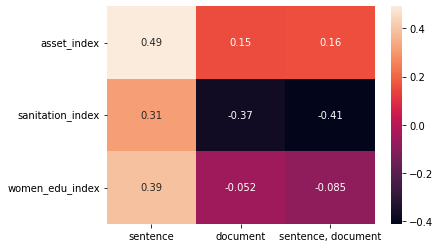

In [7]:
sns.heatmap(scores, annot=True, xticklabels=[", ".join(features) for features in FEATURES], yticklabels=TARGETS)

### Classification: logistic regression

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
 
def plot_roc_curve(y_true, y_pred, ax, title):
    ax.set_title(title)
    ax.plot([0, 1], [0, 1], "k:")
    RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_pred, ax=ax)

In [9]:
def classification(X_train, y_train, X_test, y_test, ax, title):
    base_estimator = Pipeline(steps=[("scaler", MaxAbsScaler()), ("lr", LogisticRegression(max_iter=500))])
    param_grid = {'lr__C': np.logspace(-1,2,25)}
    sklearn_search = HalvingGridSearchCV(
        base_estimator, 
        param_grid, 
        cv=3,
        factor=2,
        max_resources=100,
        error_score=0
    )

    start = time.time()
    sklearn_search.fit(X_train, y_train)
    end = time.time()
    y_pred = sklearn_search.predict(X_test)

    score = roc_auc_score(y_test, y_pred)
    print(f'sklearn HalvingGridSearchCV fit time: {round(end - start, 3)}s, roc auc: {round(score, 3)}')
    print(f'best estimator: {sklearn_search.best_estimator_}')
    print(classification_report(y_test, y_pred))
    print()
    
    plot_roc_curve(y_test, y_pred, ax, title)
    
    return score

asset_index ['sentence']
train data shape: (2150, 384), test data shape: (390, 384)
654 (30.42%) positive examples in train data, 122 (31.28%) positive examples in test data

sklearn HalvingGridSearchCV fit time: 0.628s, roc auc: 0.804
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr',
                 LogisticRegression(C=0.23713737056616552, max_iter=500))])
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       268
           1       0.70      0.75      0.73       122

    accuracy                           0.82       390
   macro avg       0.79      0.80      0.80       390
weighted avg       0.83      0.82      0.82       390



asset_index ['document']
No need to resample, classes are balanced within our tolerated class ratio of 0.3
train data shape: (9451, 300), test data shape: (1742, 300)
3053 (32.3%) positive examples in train data, 665 (38.17%) positive examples in test data

sklearn HalvingGri

/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/pipeline.p

sklearn HalvingGridSearchCV fit time: 0.856s, roc auc: 0.607
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr', LogisticRegression(C=0.1, max_iter=500))])
              precision    recall  f1-score   support

           0       0.62      0.88      0.73       639
           1       0.69      0.33      0.45       523

    accuracy                           0.63      1162
   macro avg       0.66      0.61      0.59      1162
weighted avg       0.65      0.63      0.60      1162





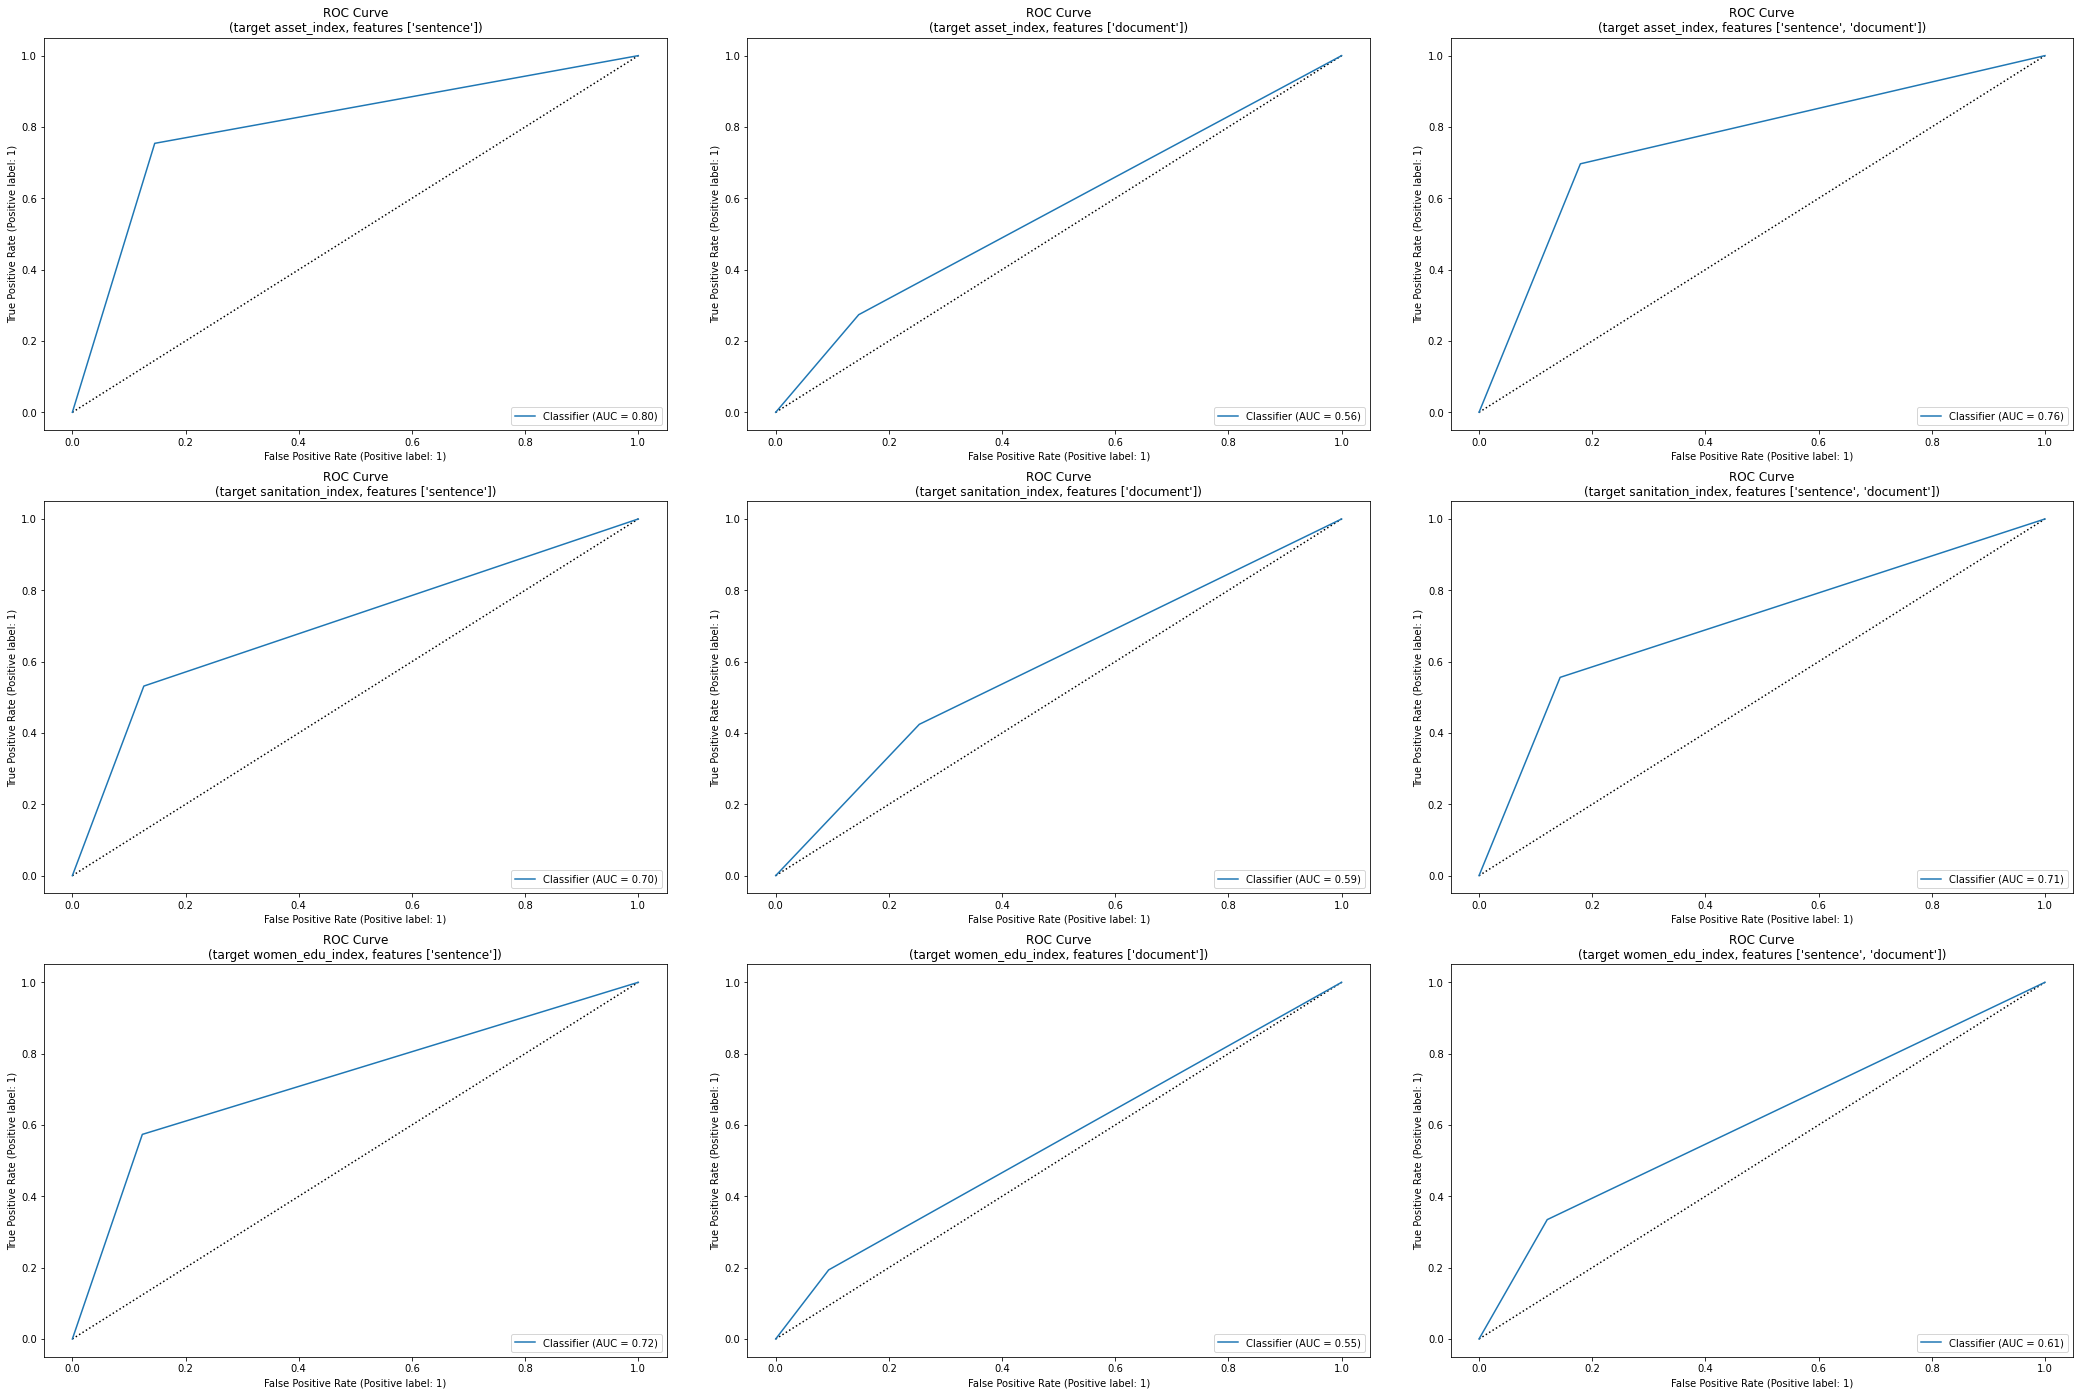

In [12]:
# ROC curves
fig, axs = plt.subplots(len(TARGETS), len(FEATURES), squeeze=False, figsize=(30,20))
fig.tight_layout(pad=5.0)

scores = np.zeros((len(TARGETS), len(FEATURES)))
for i, target in enumerate(TARGETS):
    for j, features in enumerate(FEATURES):
        ds = SustainBenchTextDataset(
            data_dir=f'/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/data/', 
            features=features, 
            target=target,
            model_type='classification',
            classification_threshold=CLASSIFICATION_THRESHOLD_DICT[target],
            rebalance=True
        )

        print(target, features)
        X_train, y_train = ds.get_data('train')
        X_test, y_test = ds.get_data('test')
        print(f'train data shape: {X_train.shape}, test data shape: {X_test.shape}')
        print(f'{sum(y_train)} ({np.round(sum(y_train)/X_train.shape[0] * 100, 2)}%) positive examples in train data, {sum(y_test)} ({np.round(sum(y_test)/X_test.shape[0] * 100, 2)}%) positive examples in test data\n')
        scores[i,j] = classification(X_train, y_train, X_test, y_test, axs[i][j], f'ROC Curve\n(target {target}, features {features})') 
        print()
        
plt.show()

<AxesSubplot:>

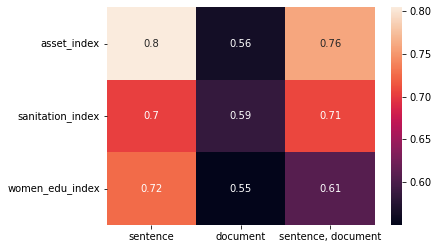

In [13]:
sns.heatmap(scores, annot=True, xticklabels=[", ".join(features) for features in FEATURES], yticklabels=TARGETS)

### Classification: basic feedforward network

In [14]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

In [15]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [16]:
def get_data_loader(features, target, rebalance=False):
    ds = SustainBenchTextDataset(
                data_dir=f'/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/data/', 
                features=features, 
                target=target,
                model_type='classification',
                classification_threshold=CLASSIFICATION_THRESHOLD_DICT[target],
                rebalance=rebalance
            )

    X_train, y_train = ds.get_data('train')
    X_test, y_test = ds.get_data('test')
    
    print(f'train data shape: {X_train.shape}, test data shape: {X_test.shape}')
    print(f'{sum(y_train)} ({np.round(sum(y_train)/X_train.shape[0] * 100, 2)}%) positive examples in train data, {sum(y_test)} ({np.round(sum(y_test)/X_test.shape[0] * 100, 2)}%) positive examples in test data\n')

    X_train = torch.Tensor(X_train)
    y_train = torch.from_numpy(y_train)
    X_test = torch.Tensor(X_test)
    y_test = torch.from_numpy(y_test)
    
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset)

    
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset)
    
    return train_loader, test_loader

In [17]:
def train(train_loader, net, learning_rate, logging=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for i, (embeddings, labels) in enumerate(train_loader):
            embeddings = Variable(embeddings)
            labels = Variable(labels)

            optimizer.zero_grad()                  
            outputs = net(embeddings)                   
            loss = criterion(outputs, labels)        
            loss.backward()                            
            optimizer.step() 

            if logging and (i+1) % 100 == 0: 
                print(f'epoch: {epoch+1}/{num_epochs}, step: {int((i+1) / 100)}/{len(train_dataset)//batch_size}, loss: {loss.data}')

    return net

In [18]:
def evaluate(test_loader, net, time_taken, ax, title):
    y_true = []
    y_pred = []
    for i, (embeddings, labels) in enumerate(test_loader):
        embeddings = Variable(embeddings)
        outputs = net(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        y_true.append(labels.item())
        y_pred.append(predicted.item())

    score = roc_auc_score(y_true, y_pred)
    print(f'basic neural network classifier fit time: {round(time_taken, 3)}s, roc auc: {round(score, 3)}')
    print(classification_report(y_true, y_pred))
    
    plot_roc_curve(y_true, y_pred, ax, title)

    return score

In [19]:
num_classes = 2
num_epochs = 5
batch_size = 100
learning_rate = 0.001
FEATURE_INPUT_SIZE_DICT = {'sentence': 384, 'document': 300}

asset_index ['sentence']
train data shape: (2142, 384), test data shape: (390, 384)
654 (30.53%) positive examples in train data, 122 (31.28%) positive examples in test data

basic neural network classifier fit time: 7.538s, roc auc: 0.601
              precision    recall  f1-score   support

           0       1.00      0.20      0.34       268
           1       0.36      1.00      0.53       122

    accuracy                           0.45       390
   macro avg       0.68      0.60      0.43       390
weighted avg       0.80      0.45      0.40       390


asset_index ['document']
No need to resample, classes are balanced within our tolerated class ratio of 0.3
train data shape: (9451, 300), test data shape: (1742, 300)
3053 (32.3%) positive examples in train data, 665 (38.17%) positive examples in test data

basic neural network classifier fit time: 27.79s, roc auc: 0.618
              precision    recall  f1-score   support

           0       0.77      0.45      0.57      1077


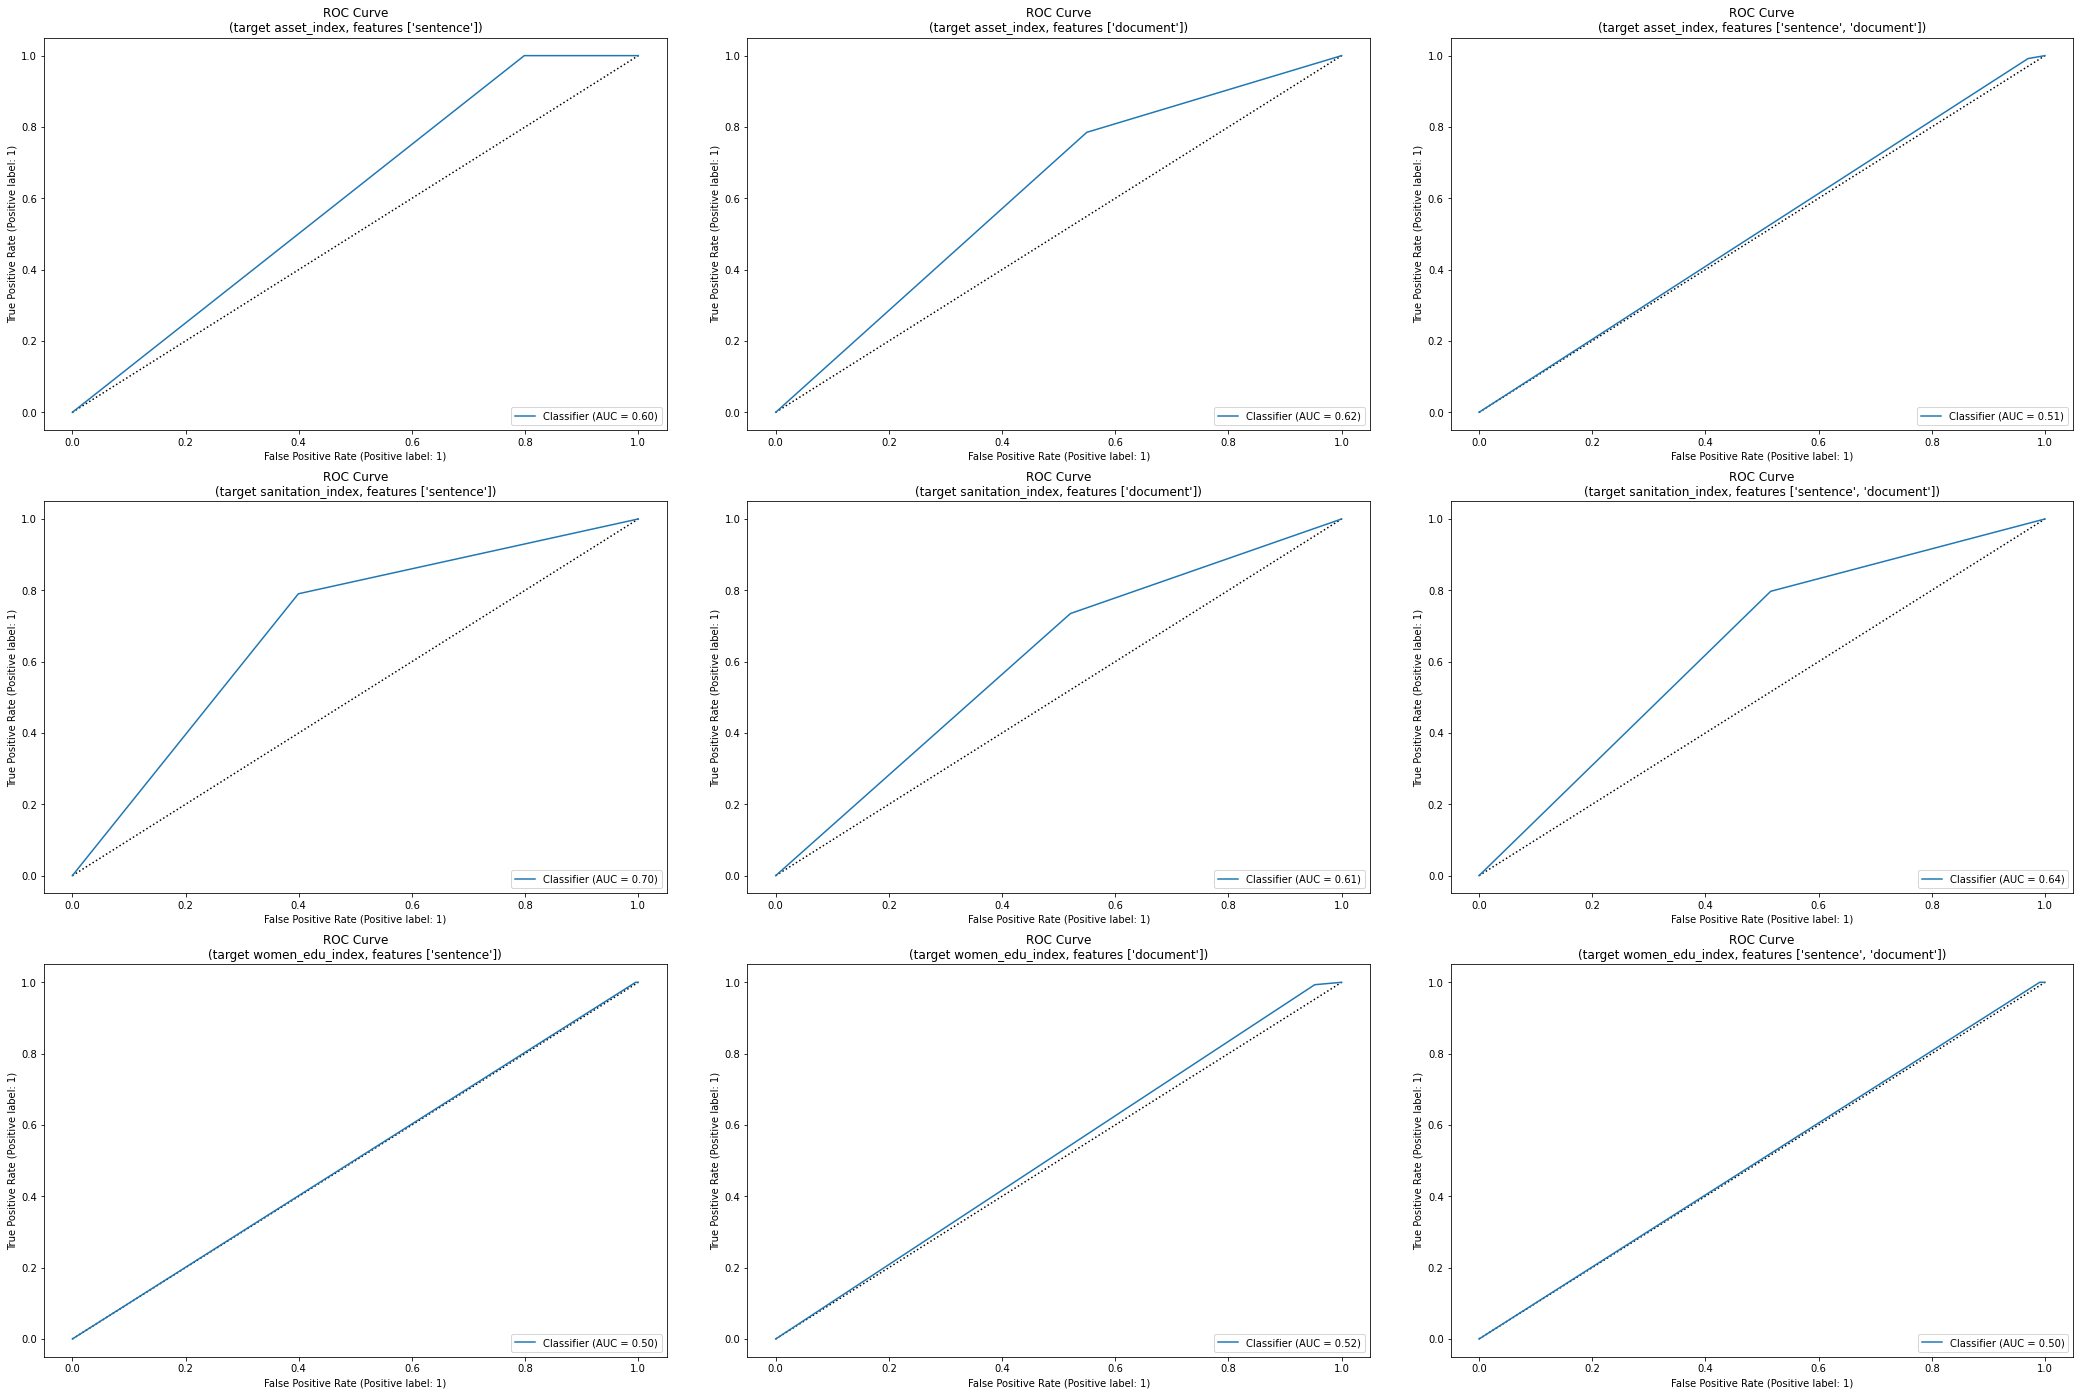

In [20]:
# ROC curves
fig, axs = plt.subplots(len(TARGETS), len(FEATURES), squeeze=False, figsize=(30,20))
fig.tight_layout(pad=5.0)

scores = np.zeros((len(TARGETS), len(FEATURES)))
for i, target in enumerate(TARGETS):
    for j, features in enumerate(FEATURES):
        print(target, features)
        input_size = sum([FEATURE_INPUT_SIZE_DICT[feature] for feature in features])
        hidden_size = int(input_size / 2)

        train_loader, test_loader = get_data_loader(features, target, rebalance=True)
        net = Net(input_size, hidden_size, num_classes)
        start = time.time()
        net = train(train_loader, net, learning_rate)
        end = time.time()
        scores[i,j] = evaluate(test_loader, net, end - start, axs[i][j], f'ROC Curve\n(target {target}, features {features})')

        print()

<AxesSubplot:>

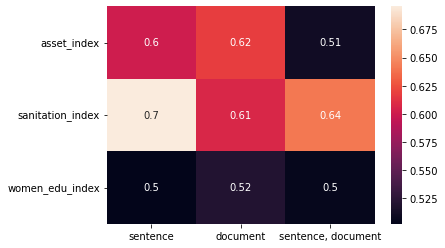

In [21]:
sns.heatmap(scores, annot=True, xticklabels=[", ".join(features) for features in FEATURES], yticklabels=TARGETS)